# DLO-JZ Optimiseurs et large batch - Jour 2 

Les cellules dans ce *notebook* ne sont pas prévues pour être modifiées, sauf rares exceptions indiquées dans les commentaires. 

*Notebook rédigé par l'équipe assistance IA de l'IDRIS, octobre 2022*


------------------------

Ce notebook est prévu pour être exécuté à partir d'une machine frontale de Jean-Zay. Le *hostname* doit être jean-zay[1-5].

In [1]:
!hostname

jean-zay3


Un module PyTorch doit avoir été chargé pour le bon fonctionnement de ce Notebook. **Nécessairement**, le module `pytorch-gpu/py3/1.11.0` :

In [2]:
!module list

Currently Loaded Modulefiles:
 1) cuda/11.2             5) openmpi/4.1.1-cuda   9) sparsehash/2.0.3        
 2) nccl/2.9.6-1-cuda     6) intel-mkl/2020.4    10) pytorch-gpu/py3/1.11.0  
 3) cudnn/8.1.1.33-cuda   7) magma/2.5.4-cuda    
 4) gcc/8.4.1(8.3.1)      8) sox/14.4.2          
>

Les fonctions *python* de gestion de queue SLURM dévelopées par l'IDRIS et les fonctions dédiées à la formation DLO-JZ sont à importer.

Le module d'environnement pour les *jobs* et la taille des images sont fixés pour ce *notebook*.

**TODO :** choisir un *pseudonyme* (maximum 5 caractères) pour vous différencier dans la queue SLURM et dans les outils collaboratifs pendant la formation et la compétition.

In [3]:
from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from dlojz_tools_tp import plot_accuracy, lrfind_plot, plot_accuracy_lr
MODULE = 'pytorch-gpu/py3/1.11.0'
account = 'for@a100'
n_gpu = 2

name = 'pseudo'  #TODO#

------------------------------------

## Dataset et modèle

Pour ce TP, on va utiliser la base de données CIFAR 10 et le modèle Resnet-18 pour pouvoir faire tourner des entrainements complets en un temps raisonnable. Le TP se fera en modifiant le code `cifar10.py`.

### CIFAR 10

#### Train set

In [4]:
import os
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([ 
        transforms.RandomHorizontalFlip(),              # Horizontal Flip - Data Augmentation
        transforms.ToTensor()                          # convert the PIL Image to a tensor
        ])
    
    
train_dataset = torchvision.datasets.CIFAR10(root=os.environ['ALL_CCFRSCRATCH']+'/CIFAR_10',
                                             train=True, download=False, transform=transform)
train_dataset

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,    
                                           batch_size=4,
                                           shuffle=True)

X train batch, shape: torch.Size([4, 3, 32, 32]), data type: torch.float32, Memory usage: 49152 bytes
Y train batch, shape: torch.Size([4]), data type: torch.int64, Memory usage: 32 bytes


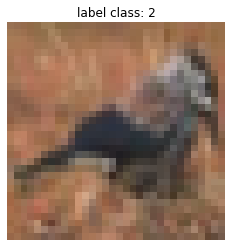

In [5]:
batch = next(iter(train_loader))
print('X train batch, shape: {}, data type: {}, Memory usage: {} bytes'
      .format(batch[0].shape, batch[0].dtype, batch[0].element_size()*batch[0].nelement()))
print('Y train batch, shape: {}, data type: {}, Memory usage: {} bytes'
      .format(batch[1].shape, batch[1].dtype, batch[1].element_size()*batch[1].nelement()))

img = batch[0][0].numpy().transpose((1,2,0))
plt.imshow(img)
plt.axis('off')
_ = plt.title('label class: {}'.format(batch[1][0].numpy()))

#### Validation set

In [6]:
val_transform = transforms.Compose([
                    transforms.ToTensor()                           # convert the PIL Image to a tensor
                    ])
    
val_dataset = torchvision.datasets.CIFAR10(root=os.environ['ALL_CCFRSCRATCH']+'/CIFAR_10',
                                               train=False, download=False, transform=val_transform)
val_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /gpfsscratch/idris/for/commun/CIFAR_10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Resnet-18

In [7]:
model = models.resnet18()
print('number of total parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
print('number of trainable parameters: {}'.format(sum([p.numel() for p in model.parameters() if p.requires_grad])))

number of total parameters: 11689512
number of trainable parameters: 11689512


-----------

## Description

Nous étudierons 4 *optimizer* (SGD, AdamW, LAMB et LARS).

A chaque fois nous regarderons le cas d'un apprentissage **Small Batch** et le cas d'un apprentissage **Large Batch**.

 * **Small Batch** : *Global Batch Size* de **256** sur 2 GPU sur **30** *epochs*
 * **Large Batch** : *Global Batch Size* de **8192** sur 2 GPU sur **50** *epochs* 


**Remarque** : 

Le paramètre *wrapped_optimizer* est présent dans le code à cause de l'implémentation de LARS spécifiquement. Car le *LR scheduler* doit prendre en entrée l'*optimizer SGD* de base non *wrapped*. 

Pour les autres *optimizers*, il ne sert à rien. Mais cette astuce permet de basculer sur chaque type d'*optimizer* facilement. 

------------------------------------

### *LR Finder*

Dans le but d'utiliser un *Cycle Scheduler*, il nous faut d'abord trouver l'intervalle des valeurs du *learning rate* qui auront un effet positif sur l'apprentissage du modèle.

On va lancer le script 'cifar10.py' avec l'option `--findlr` ce qui va lancer l'entrainement sur quelques *epochs* durant lesquelles le *learning rate* va doucement augmenter.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [8]:
command = [f'cifar10.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10.py -b 4096 -e 20 --findlr --lr 5.']
jobid_sgd_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_sgd_lrf = {jobid_sgd_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392317
Submitted batch job 392318
jobid_sgd_lrf = ['392317', '392318']


In [9]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            392317    gpu_p5   pseudo  cfor032  R       0:48      1 jean-zay-iam03

 Done!


In [10]:
jobid_sgd_lrf = ['392317', '392318']

Vous pouvez maintenant tracer la courbe de la *loss* en fonction du *learning rate*.

#### Small Batch

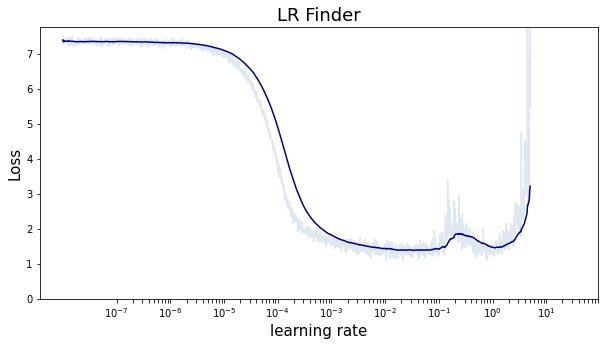

In [11]:
lrfind_plot(jobid_sgd_lrf[:1])

La courbe transparente représente les valeurs réelles, la courbe opaque représente un lissage de ces valeurs.

À partir de cette courbe, vous pouvez trouver les valeurs minimale et maximale acceptables du *learning rate*.

#### Large Batch

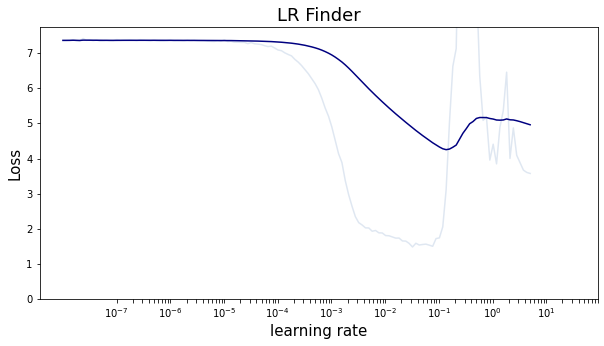

In [12]:
lrfind_plot(jobid_sgd_lrf[1:])

------------------------------------

### *Learning Rate* constant (référence)

On va lancer un entrainement de référence avec un *learning rate* constant.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par la valeur de *learning rate* choisie**

In [13]:
lr = 0.1
command = f'cifar10.py -b 128 -e 30 --wd 5e-3 --lr {lr}'
jobid1 = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid1 = {jobid1}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392353
jobid1 = ['392353']


In [14]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            392353    gpu_p5   pseudo  cfor032  R       2:00      1 jean-zay-iam03

 Done!


In [15]:
jobid1 = ['392353']

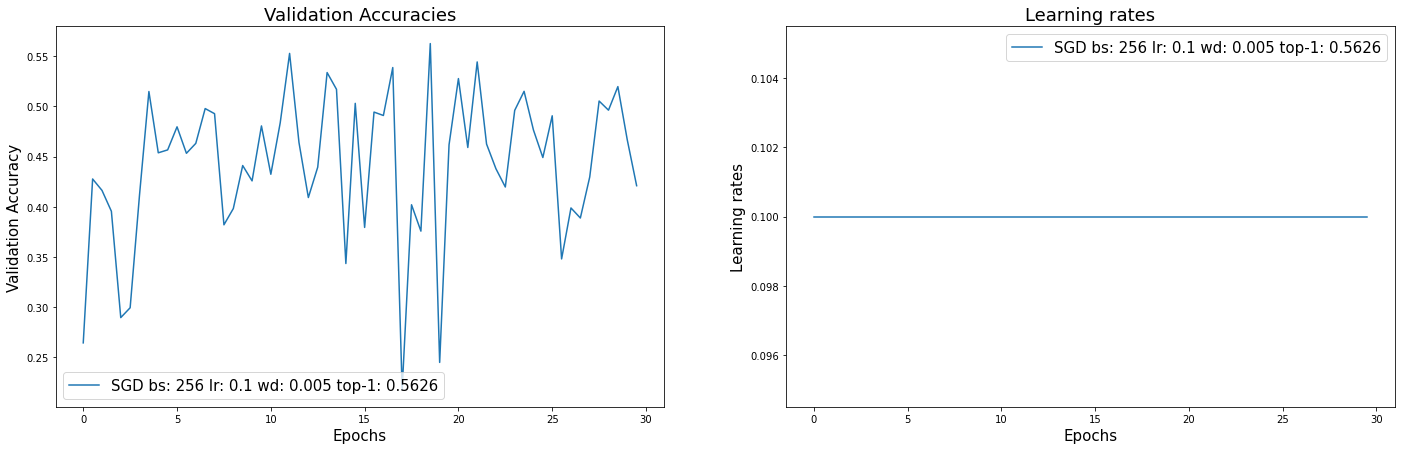

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.5626 >>> Training complete in: 0:01:32.742002


In [16]:
jobids=[jobid1]
plot_accuracy_lr(jobids)

### *One Cycle Learning Rate*

Nous allons maintenant modifier le code pour remplacer le *learning rate* constant par un *One Cycle Scheduler* et comparer le résultat avec l'entrainement de référence.

**TODO** : dans le script `cifar10.py`:
* Trouver la ligne de déclaration du *Learning Rate Scheduler* :

```python
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1, total_iters=5)
```
* Le remplacer par un *One Cycle Scheduler* 

```python
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, steps_per_epoch=N_batch, epochs=args.epochs)
```

__Remarque__ : Le *OneCycleLR* de PyTorch calcule automatiquement une valeur minimale de *learning rate* à partir de la valeur maximale donnée.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch)**

In [18]:
lr_smallb = 0.1
lr_largeb = 0.1
command = [f'cifar10.py -b 128 -e 30 --wd 5e-3 --lr {lr_smallb}', 
           f'cifar10.py -b 4096 -e 50 --wd 5e-3 --lr {lr_largeb}']
jobid_sgd = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_sgd = {jobid_sgd}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392386
Submitted batch job 392388
jobid_sgd = ['392386', '392388']


In [19]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            392386    gpu_p5   pseudo  cfor032 CG       1:45      1 jean-zay-iam03

 Done!


In [20]:
jobid_sgd = ['392386', '392388']

Vous pouvez comparer les courbes de *test accuracy* et de *learning rate* avec l'entrainement de référence.

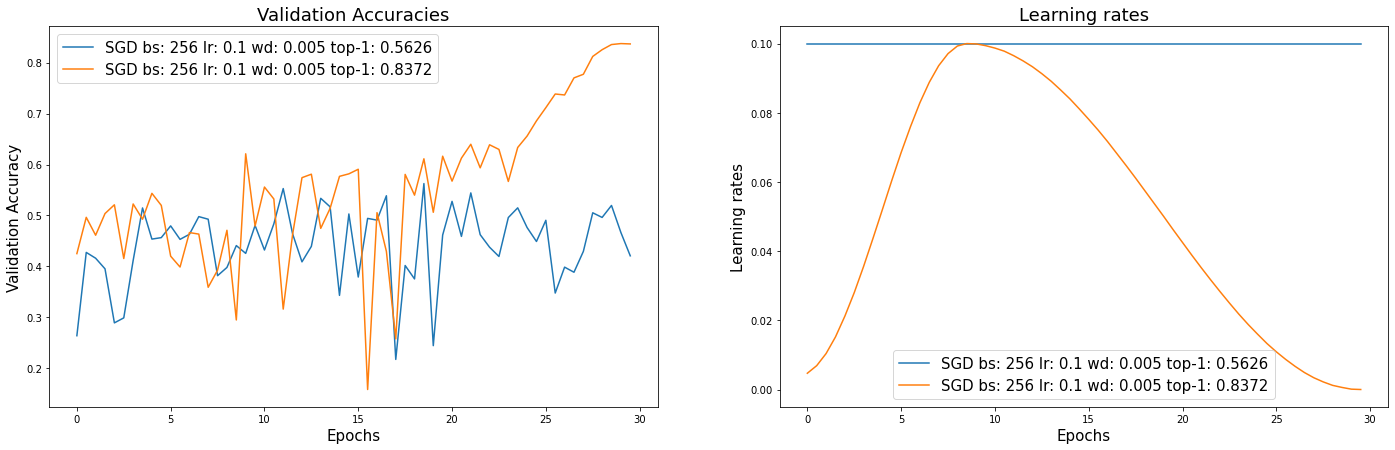

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.5626 >>> Training complete in: 0:01:32.742002
Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8372 >>> Training complete in: 0:01:32.007068


In [21]:
jobids=[jobid1, jobid_sgd[:1]]
plot_accuracy_lr(jobids)

------------------------------------

### Optimiseur *AdamW*

On va maintenant modifier l'optimiseur pour utiliser *AdamW*.

**TODO** : dans le script `cifar10.py`:
* Trouver la ligne de déclaration de l'optimiseur *Stochastic Gradient Descent* :

```python
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.mom, weight_decay=args.wd)
```
* Le remplacer par l'optimiseur *Adam* :

```python
optimizer = torch.optim.AdamW(model.parameters(), args.lr, betas=(args.mom, 0.999), weight_decay=args.wd)
```

L'optimiseur ayant changé il nous faut recalculer la valeur de *learning rate* maximale à donner en paramètre :

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.


In [22]:
command = [f'cifar10.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10.py -b 4096 -e 20 --findlr --lr 5.']
jobid_adam_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_adam_lrf = {jobid_adam_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392485
Submitted batch job 392486
jobid_adam_lrf = ['392485', '392486']


In [25]:
display_slurm_queue(name)


 Done!


In [26]:
jobid_adam_lrf = ['392485', '392486']

#### Small batch

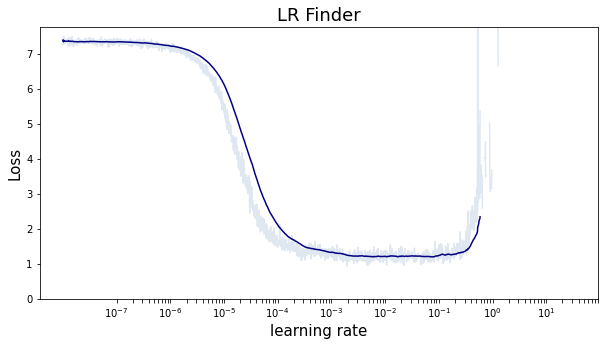

In [27]:
lrfind_plot(jobid_adam_lrf[:1])

#### Large batch

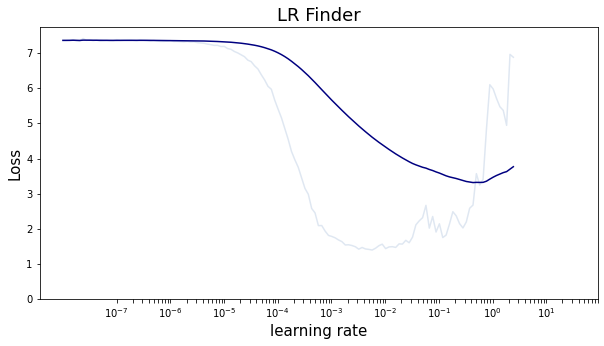

In [28]:
lrfind_plot(jobid_adam_lrf[1:])

Vous pouvez maintenant lancer l'entrainement avec l'optimiseur *AdamW*.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch)**

In [29]:
lr_smallb = 0.1
lr_largeb = 0.1
command = [f'cifar10.py -b 128 -e 30 --wd 1e-1 --lr {lr_smallb}', 
           f'cifar10.py -b 4096 -e 50 --wd 1e-1 --lr {lr_largeb}']
jobid_adamw = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_adamw = {jobid_adamw}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392515
Submitted batch job 392516
jobid_adamw = ['392515', '392516']


In [30]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            392515    gpu_p5   pseudo  cfor032  R       2:04      1 jean-zay-iam03

 Done!


In [31]:
jobid_adamw = ['392515', '392516']

Vous pouvez comparer les courbes de *test accuracy* et de *train accuracy* avec les entrainements précédents.

#### Small batch

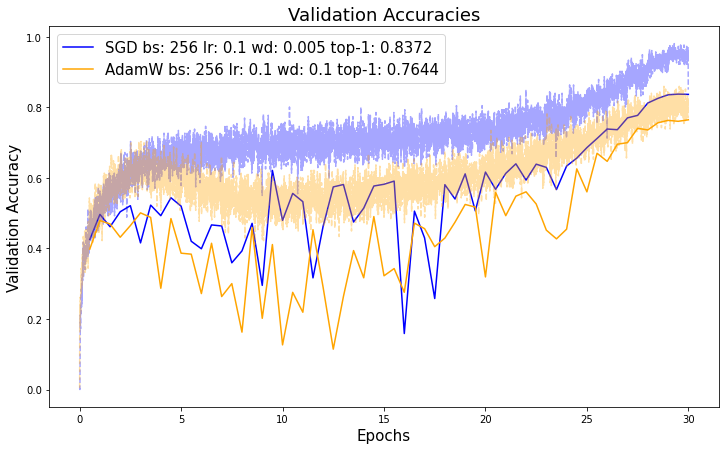

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8372 >>> Training complete in: 0:01:32.007068
Resnet-18: AdamW bs: 256 lr: 0.1 wd: 0.1 top-1: 0.7644 >>> Training complete in: 0:01:43.455012


In [32]:
jobids=[jobid_sgd[:1], jobid_adamw[:1]]
plot_accuracy(jobids)

#### Large batch

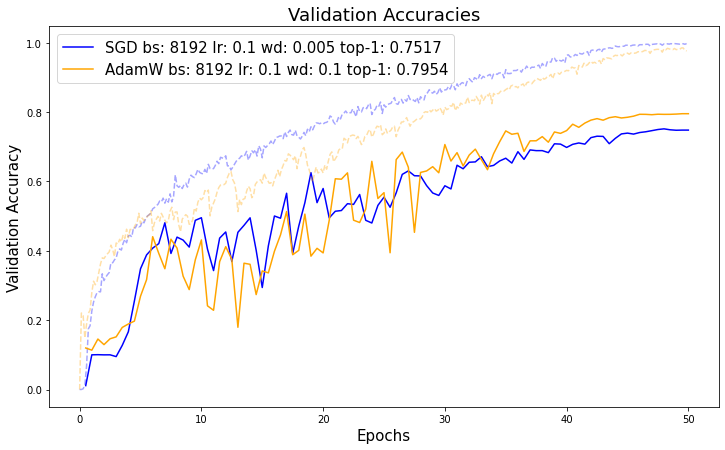

Resnet-18: SGD bs: 8192 lr: 0.1 wd: 0.005 top-1: 0.7517 >>> Training complete in: 0:01:00.318440
Resnet-18: AdamW bs: 8192 lr: 0.1 wd: 0.1 top-1: 0.7954 >>> Training complete in: 0:01:04.562515


In [33]:
jobids=[jobid_sgd[1:], jobid_adamw[1:]]
plot_accuracy(jobids)

------------------------------------

### Optimiseur *LAMB*

On va maintenant modifier l'optimiseur pour utiliser *LAMB*.

**TODO** : dans le script `cifar10.py`:
* Remplacer l'optimiseur *AdamW* par l'optimiseur *LAMB* :

```python
optimizer = apex.optimizers.FusedLAMB(model.parameters(), args.lr, betas=(args.mom, 0.999), weight_decay=args.wd)
```

Il faut maintenant à nouveau toruver la valeur de *learning rate* maximale à donner en paramètre pour cet optimiseur :

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [34]:
command = [f'cifar10.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10.py -b 4096 -e 20 --findlr --lr 5.']
jobid_lamb_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lamb_lrf = {jobid_lamb_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392536
Submitted batch job 392537
jobid_lamb_lrf = ['392536', '392537']


In [35]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            392536    gpu_p5   pseudo  cfor032  R       0:46      1 jean-zay-iam03
            392537    gpu_p5   pseudo  cfor032  R       0:46      1 jean-zay-iam03

 Done!


In [36]:
jobid_lamb_lrf = ['392536', '392537']

#### Small Batch

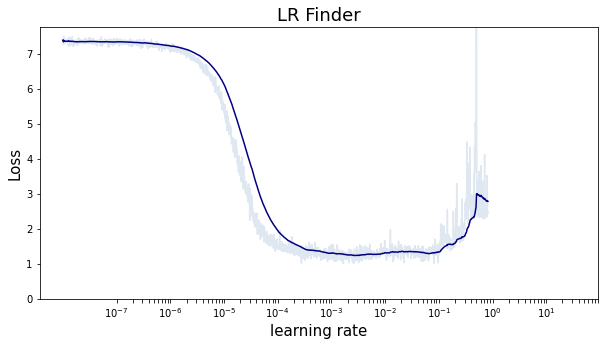

In [37]:
lrfind_plot(jobid_lamb_lrf[:1])

#### Large Batch

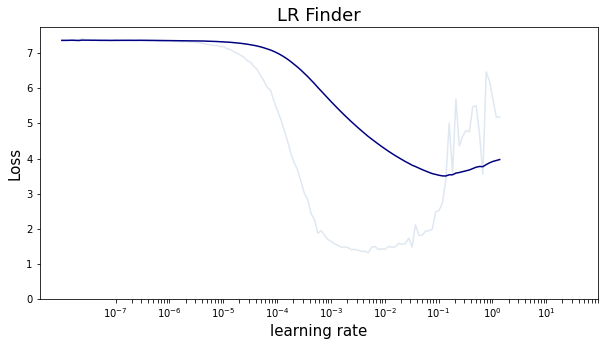

In [38]:
lrfind_plot(jobid_lamb_lrf[1:])

Vous pouvez maintenant lancer l'entrainement avec l'optimiseur LAMB.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch)**

In [39]:
lr_smallb = 0.01
lr_largeb = 0.01
command = [f'cifar10.py -b 128 -e 30 --wd 1e-1 --lr {lr_smallb}', 
           f'cifar10.py -b 4096 -e 50 --wd 1e-1 --lr {lr_largeb}']
jobid_lamb = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lamb = {jobid_lamb}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392583
Submitted batch job 392592
jobid_lamb = ['392583', '392592']


In [40]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            392583    gpu_p5   pseudo  cfor032  R       1:36      1 jean-zay-iam03

 Done!


In [41]:
jobid_lamb = ['392583', '392592']

Vous pouvez comparer les courbes de *test accuracy* et de *train accuracy* avec les entrainements précédents.

#### Small Batch

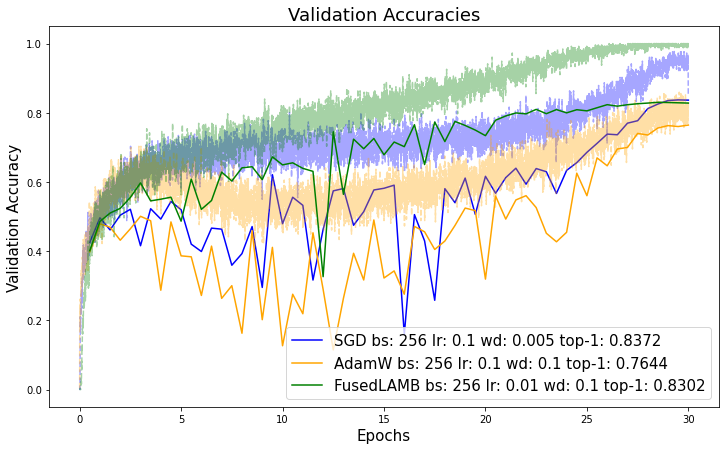

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8372 >>> Training complete in: 0:01:32.007068
Resnet-18: AdamW bs: 256 lr: 0.1 wd: 0.1 top-1: 0.7644 >>> Training complete in: 0:01:43.455012
Resnet-18: FusedLAMB bs: 256 lr: 0.01 wd: 0.1 top-1: 0.8302 >>> Training complete in: 0:01:23.946907


In [42]:
jobids=[jobid_sgd[:1], jobid_adamw[:1], jobid_lamb[:1]]
plot_accuracy(jobids)

#### Large Batch

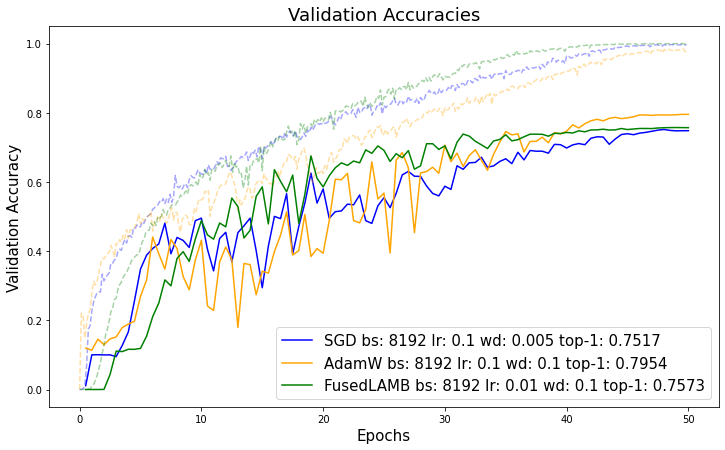

Resnet-18: SGD bs: 8192 lr: 0.1 wd: 0.005 top-1: 0.7517 >>> Training complete in: 0:01:00.318440
Resnet-18: AdamW bs: 8192 lr: 0.1 wd: 0.1 top-1: 0.7954 >>> Training complete in: 0:01:04.562515
Resnet-18: FusedLAMB bs: 8192 lr: 0.01 wd: 0.1 top-1: 0.7573 >>> Training complete in: 0:01:02.677729


In [43]:
jobids=[jobid_sgd[1:], jobid_adamw[1:], jobid_lamb[1:]]
plot_accuracy(jobids)

### Optimiseur *LARS*

Pour finir nous allons essayer un entrainement large batch avec l'optimiseur LARS ou LARC (optimisation apex de LARS)

**TODO** : dans le script `cifar10.py`:
* Remplacer l'optimiseur *LAMB* par l'optimiseur *LARC* :

```python
optimizer = ...

wrapped_optimizer = optimizer
```
par

```python
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.mom, weight_decay=args.wd)
    
wrapped_optimizer = LARC(optimizer)
```

Il faut maintenant à nouveau trouver la valeur de *learning rate* maximale à donner en paramètre pour cet optimiseur :

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [44]:
command = [f'cifar10.py -b 128 -e 10 --findlr --lr 5.', 
           f'cifar10.py -b 4096 -e 20 --findlr --lr 5.']
jobid_lars_lrf = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lars_lrf = {jobid_lars_lrf}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392796
Submitted batch job 392797
jobid_lars_lrf = ['392796', '392797']


In [45]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            392796    gpu_p5   pseudo  cfor032  R       0:58      1 jean-zay-iam04

 Done!


In [46]:
jobid_lars_lrf = ['392796', '392797']

#### Small Batch

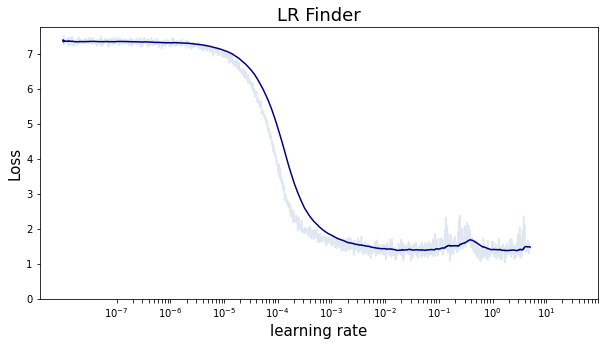

In [47]:
lrfind_plot(jobid_lars_lrf[:1])

#### Large Batch

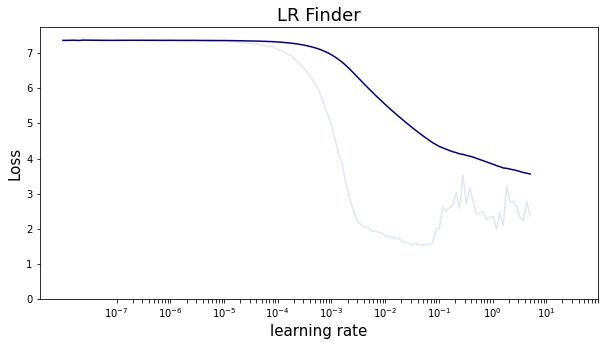

In [48]:
lrfind_plot(jobid_lars_lrf[1:])

Vous pouvez maintenant lancer l'entrainement avec l'optimiseur LARS.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

**TODO : remplacer XXX par les valeurs maximales de *learning rate* choisies (Small Batch et Large Batch)**

In [49]:
lr_smallb = 1
lr_largeb = 0.5
command = [f'cifar10.py -b 128 -e 30 --wd 5e-3 --lr {lr_smallb}', 
           f'cifar10.py -b 4096 -e 50 --wd 5e-3 --lr {lr_largeb}']
jobid_lars = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_lars = {jobid_lars}')

batch job 0: 2 GPUs distributed on 1 nodes with 2 tasks / 2 gpus per node and 8 cpus per task
Submitted batch job 392816
Submitted batch job 392820
jobid_lars = ['392816', '392820']


In [50]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            392816    gpu_p5   pseudo  cfor032 CG       2:40      1 jean-zay-iam03

 Done!


In [51]:
jobid_lars = ['392816', '392820']

Vous pouvez comparer les courbes de *test accuracy* et de *train accuracy* avec les entrainements précédents.

#### Small Batch

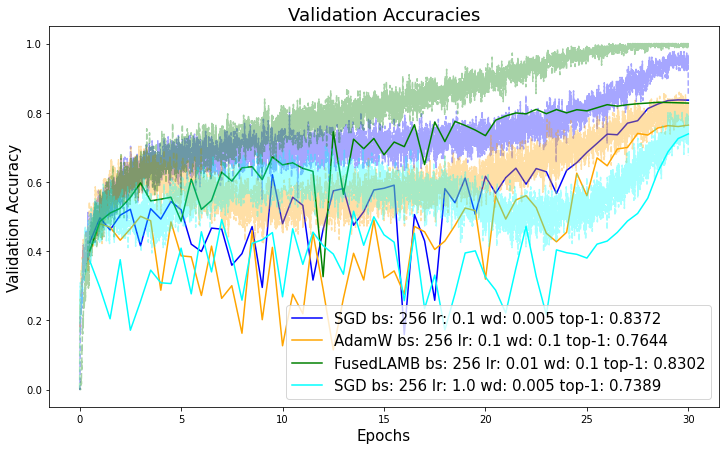

Resnet-18: SGD bs: 256 lr: 0.1 wd: 0.005 top-1: 0.8372 >>> Training complete in: 0:01:32.007068
Resnet-18: AdamW bs: 256 lr: 0.1 wd: 0.1 top-1: 0.7644 >>> Training complete in: 0:01:43.455012
Resnet-18: FusedLAMB bs: 256 lr: 0.01 wd: 0.1 top-1: 0.8302 >>> Training complete in: 0:01:23.946907
Resnet-18: SGD bs: 256 lr: 1.0 wd: 0.005 top-1: 0.7389 >>> Training complete in: 0:02:27.663093


In [52]:
jobids=[jobid_sgd[:1], jobid_adamw[:1], jobid_lamb[:1], jobid_lars[:1]]
plot_accuracy(jobids)

#### Large Batch

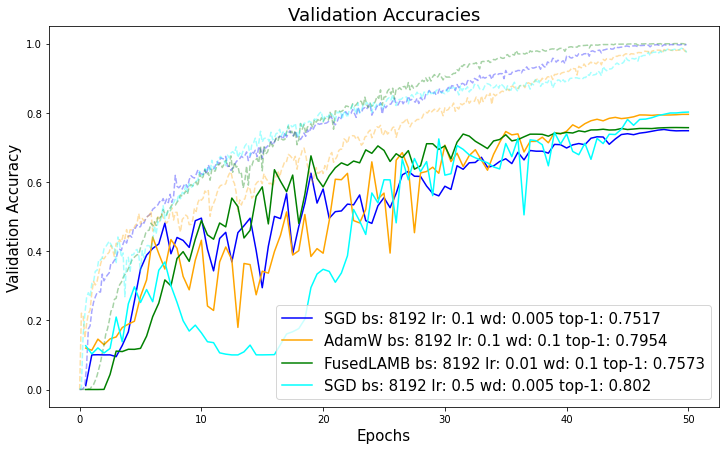

Resnet-18: SGD bs: 8192 lr: 0.1 wd: 0.005 top-1: 0.7517 >>> Training complete in: 0:01:00.318440
Resnet-18: AdamW bs: 8192 lr: 0.1 wd: 0.1 top-1: 0.7954 >>> Training complete in: 0:01:04.562515
Resnet-18: FusedLAMB bs: 8192 lr: 0.01 wd: 0.1 top-1: 0.7573 >>> Training complete in: 0:01:02.677729
Resnet-18: SGD bs: 8192 lr: 0.5 wd: 0.005 top-1: 0.802 >>> Training complete in: 0:01:02.462971


In [53]:
jobids=[jobid_sgd[1:], jobid_adamw[1:], jobid_lamb[1:], jobid_lars[1:]]
plot_accuracy(jobids)

--------------

## Annexe

Avec l'*optimizer* de votre choix (Il faudra modifier le code en fonction) :

Vous pouvez faire d'autres tests en jouant sur les différents paramètres :
* Nombre d'epoch
* La valeur du *weight decay*
* La valeur du *learning rate*
* La taille de batch. Attention : **sur 2 GPU**, donc la taille de *batch* sera **multipliée par 2**.

In [ ]:
n_epoch = 
weight_decay = 
lr = 
batch_size = 
command = f'cifar10.py -b {batch_size} -e {n_epoch} --wd {weight_decay} --lr {lr}'

#### LR finder (Optionnel)

In [ ]:
command_lr = f'cifar10.py -b {batch_size} -e 20 --findlr --lr 5. --wd {weight_decay}'
jobid_test_lrf = gpu_jobs_submitter(command_lr, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_test_lrf = {jobid_test_lrf}')

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid_test_lrf =

In [ ]:
lrfind_plot(jobid_test_lrf)

#### Apprentissage

In [ ]:
jobid_test = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00')
print(f'jobid_test = {jobid_test}')

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid_test = ['428']

In [ ]:
plot_accuracy(jobid_test)

--------------